In [1]:


import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
from math import pi


os.environ["LOKY_MAX_CPU_COUNT"] = "4"

# 1. Load and prepare dataset
df = pd.read_csv("data/Linhac24-25_Sportlogiq.csv")
df = df.sort_values(by=['gameid', 'compiledgametime'])

# ========== 2. Event flags with renamed variables ==========
df['num_passes'] = (df['eventname'] == 'pass').astype(int)
df['num_zone_entries'] = (df['eventname'] == 'controlledentry').astype(int)
df['num_assists'] = (df['eventname'] == 'assist').astype(int)
df['num_blocks'] = (df['eventname'] == 'block').astype(int)
df['num_entries_against'] = (df['eventname'] == 'controlledentryagainst').astype(int)
df['num_dumpouts'] = (df['eventname'] == 'dumpout').astype(int)
df['num_shots'] = df['eventname'].isin(['shot', 'goal']).astype(int)

# ========== 3. Success flags ==========
df['num_successful_passes'] = ((df['eventname'] == 'pass') & (df['outcome'] == 'successful')).astype(int)
df['num_successful_zone_entries'] = ((df['eventname'] == 'controlledentry') & (df['outcome'] == 'successful')).astype(int)
df['num_successful_entries_against'] = ((df['eventname'] == 'controlledentryagainst') & (df['outcome'] == 'successful')).astype(int)

# ========== 4. Carry duration & distance ==========
df['is_carry'] = (df['eventname'] == 'carry').astype(int)
carry_df = df[df['is_carry'] == 1].copy()
carry_df['next_x'] = df['xadjcoord'].shift(-1)
carry_df['next_y'] = df['yadjcoord'].shift(-1)
carry_df['carry_distance'] = np.sqrt((carry_df['next_x'] - carry_df['xadjcoord'])**2 + (carry_df['next_y'] - carry_df['yadjcoord'])**2)
carry_df['carry_duration'] = df['compiledgametime'].shift(-1) - carry_df['compiledgametime']
carry_avg = carry_df.groupby(['teamid', 'gameid'])[['carry_distance', 'carry_duration']].mean().reset_index()
carry_avg.rename(columns={'carry_distance': 'avg_carry_distance', 'carry_duration': 'avg_carry_duration'}, inplace=True)

# ========== 5. Aggregated metrics ==========
agg_cols = [
    'num_passes', 'num_successful_passes', 'num_zone_entries', 'num_successful_zone_entries',
    'num_assists', 'num_blocks', 'num_entries_against', 'num_dumpouts', 'num_shots'
]
agg_dict = {col: 'sum' for col in agg_cols}
agg_dict['xg_allattempts'] = 'mean'
agg_df = df.groupby(['teamid', 'gameid']).agg(agg_dict).reset_index()
agg_df = agg_df.merge(carry_avg, on=['teamid', 'gameid'], how='left')

# ========== 6. Final score + result ==========
last_score = df.sort_values(['gameid', 'compiledgametime']).groupby(['teamid', 'gameid'])['scoredifferential'].last().reset_index()
agg_df = agg_df.drop(columns='scoredifferential', errors='ignore')
agg_df = agg_df.merge(last_score, on=['teamid', 'gameid'], how='left')
agg_df['result'] = agg_df['scoredifferential'].apply(lambda x: 1 if x > 0 else (0 if x < 0 else 0.5))

# ========== 7. Derived success rates ==========
agg_df['pass_success_rate'] = agg_df['num_successful_passes'] / agg_df['num_passes'].replace(0, np.nan)
agg_df['entry_success_rate'] = agg_df['num_successful_zone_entries'] / agg_df['num_zone_entries'].replace(0, np.nan)

entry_against_stats = df.groupby(['teamid', 'gameid'])[['num_successful_entries_against', 'num_entries_against']].sum().reset_index()
entry_against_stats['entry_against_success_rate'] = entry_against_stats['num_successful_entries_against'] / entry_against_stats['num_entries_against'].replace(0, np.nan)
agg_df = agg_df.merge(entry_against_stats[['teamid', 'gameid', 'entry_against_success_rate']], on=['teamid', 'gameid'], how='left')

# ========== 8. Feature list for clustering ==========
features_v2 = [
    'num_passes', 'num_zone_entries', 'num_assists', 'num_blocks',
    'num_entries_against', 'num_dumpouts', 'num_shots', 'xg_allattempts',
    'pass_success_rate', 'entry_success_rate', 'entry_against_success_rate',
    'avg_carry_duration', 'avg_carry_distance'
]

scaler = StandardScaler()
X_full = scaler.fit_transform(agg_df[features_v2])

# 拟合 KMeans（这是你的“原始模型”）
kmeans_base = KMeans(n_clusters=3, random_state=42)
kmeans_base.fit(X_full)

# 保存原聚类标签和风格映射
agg_df['cluster'] = kmeans_base.predict(X_full)
style_names = {0: 'Puck Control Play', 1: 'Defensive Counterattack', 2: 'High-Pressure Offense'}
agg_df['style'] = agg_df['cluster'].map(style_names)

In [11]:
from sklearn.metrics import silhouette_score

# X_full 是标准化后的聚类输入特征矩阵
# kmeans_base.labels_ 是 KMeans 拟合后的聚类标签
score = silhouette_score(X_full, kmeans_base.labels_)
print(f"Silhouette Score: {score:.4f}")


Silhouette Score: 0.1148


Silhouette Score: 0.1380
Silhouette Score: 0.1148
Silhouette Score: 0.0989
Silhouette Score: 0.0860
Silhouette Score: 0.0849


c:\Users\yanjie\anaconda3\envs\hockey\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\yanjie\anaconda3\envs\hockey\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\yanjie\anaconda3\envs\hockey\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\yanjie\anaconda3\envs\hockey\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarn

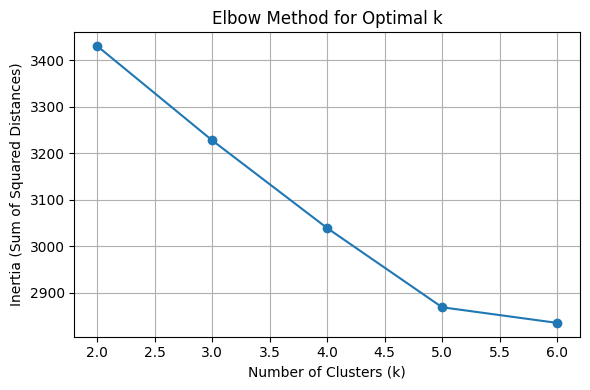

In [17]:

inertia = []
K_range = range(2, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_full)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(X_full, kmeans.labels_)
    print(f"Silhouette Score: {score:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show()

得分普遍 低于 0.2，说明聚类结构的紧密度和分离度都不强；对于复杂行为（如球队战术风格），这类分布较常见.

k ≈ 3 或 4 是可能的“肘部”位置;

更重要的是，在 k=3 的情形下，所得到的三种风格（高压进攻、防守反击、控球推进）具有清晰的战术语义，并在可视化上呈现出显著差异。这种结构同时兼顾了聚类算法的数学优化与冰球战术分析的可解释性，因此我们最终选定 k=3 作为聚类数量。

To determine the optimal number of clusters k, we applied two widely used evaluation methods: the Silhouette Score and the Elbow Method. Although the absolute values of the Silhouette Scores were relatively low across all k, the score peaked at k=3, suggesting a relatively better balance between intra-cluster cohesion and inter-cluster separation at this level. The Elbow plot further supported this choice, as k=3 marked a noticeable inflection point, beyond which the marginal gain in reducing within-cluster variance (inertia) diminished significantly.

In addition to these quantitative indicators, the choice of k=3 yielded three interpretable and semantically distinct team playing styles—Puck Control Play, Defensive Counterattack, and High-Pressure Offense.

In [5]:
from math import pi

def plot_radar(style_means, features, run_label):
    # 归一化处理（每轮内部归一化）
    normed = (style_means - style_means.min()) / (style_means.max() - style_means.min())
    normed = normed.clip(lower=0.05)

    labels = features
    angles = [n / float(len(labels)) * 2 * pi for n in range(len(labels))]
    angles += angles[:1]  # 闭环

    plt.figure(figsize=(7, 6))
    colors = sns.color_palette("Set2", n_colors=len(normed))

    for idx, (style_name, row) in enumerate(normed.iterrows()):
        values = row.tolist() + [row.tolist()[0]]
        plt.polar(angles, values, label=style_name, color=colors[idx])
        plt.fill(angles, values, alpha=0.1, color=colors[idx])

    plt.xticks(angles[:-1], labels, fontsize=8)
    plt.title(f"Radar Chart for Clusters - {run_label}", size=13)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()


In [7]:
# === Repeat stability test without ace_tools ===
results = []

for i in range(10):  # 你可以改成 10 次甚至更多
    # 重新划分训练测试集（比如按比赛划分）
    _, sample_df = train_test_split(agg_df, test_size=0.5, random_state=i)

    # 特征提取与标准化（使用原模型的scaler）
    X_sample = scaler.transform(sample_df[features_v2])

    # 使用原模型的中心预测（保持风格定义一致）
    clusters = kmeans_base.predict(X_sample)
    sample_df['cluster'] = clusters
    sample_df['style'] = sample_df['cluster'].map(style_names)

    # 计算该轮每种风格的平均胜率
    round_mean = sample_df.groupby('style')['result'].mean()
    round_mean.name = f'run_{i+1}'
    results.append(round_mean)
        # 特征雷达图
    #style_means_sample = sample_df.groupby('style')[features_v2].mean()
    #plot_radar(style_means_sample, features_v2, run_label=f"Run {i+1}")

# 合并为一个DataFrame展示
stability_df = pd.concat(results, axis=1).T
print("Repeat stability test across different samples:")
print(stability_df.round(3))

# 保存为CSV（可选）
# stability_df.to_csv("style_winrate_stability.csv")


Repeat stability test across different samples:
style   Defensive Counterattack  High-Pressure Offense  Puck Control Play
run_1                     0.608                  0.453              0.310
run_2                     0.554                  0.518              0.222
run_3                     0.631                  0.477              0.259
run_4                     0.618                  0.473              0.312
run_5                     0.603                  0.508              0.261
run_6                     0.625                  0.468              0.442
run_7                     0.644                  0.475              0.276
run_8                     0.586                  0.518              0.360
run_9                     0.586                  0.533              0.250
run_10                    0.672                  0.463              0.318


In [4]:
def compute_team_win_rate(agg_df):
    agg_df = agg_df[['teamid', 'gameid', 'result']]
    # Calculate win rate: proportion of games won (result == 1)
    winrate4team = agg_df.groupby('teamid')['result'].agg(
        wins=lambda x: (x == 1).sum(),  # number of wins
        total='count'                   # total number of games
    ).reset_index()
    winrate4team['win_rate'] = winrate4team['wins'] / winrate4team['total']
    winrate4team = winrate4team[['teamid', 'win_rate']]  # drop intermediate columns

    return winrate4team

def win_rate_and_puck_frequency(agg_df, save_df=False):
    """
    Compute each team's overall win rate and frequency of 'puck control' style (cluster 0).

    Args:
        agg_df (pd.DataFrame): Input DataFrame containing columns ['teamid', 'gameid', 'result', 'cluster'].
        save_df (bool): Whether to save the result as a CSV file (default is False).

    Returns:
        pd.DataFrame: A DataFrame containing each team's win rate and puck control frequency,
                      with columns ['team_id', 'win_rate', 'puck_control_frequency'].
    """
    winrate4team = compute_team_win_rate(agg_df)
    # Only keep necessary columns
    agg_df = agg_df[['teamid', 'gameid', 'result', 'cluster']]

    # Calculate puck control frequency: proportion of games where cluster == 0 (puck control style)
    puck_fre = agg_df.groupby('teamid')['cluster'].agg(
        puck_control_times=lambda x: (x == 0).sum(),  # number of puck-control style games
        total='count'                                 # total number of games
    ).reset_index()
    puck_fre['puck_control_frequency'] = puck_fre['puck_control_times'] / puck_fre['total']
    puck_fre = puck_fre[['teamid', 'puck_control_frequency']]  # drop intermediate columns

    # Merge win rate and puck control frequency on teamid
    puck_fre_and_win_rate = pd.merge(winrate4team, puck_fre, on='teamid')
    puck_fre_and_win_rate.columns = ['team_id', 'win_rate', 'puck_control_frequency']

    # Optionally save to CSV
    if save_df:
        puck_fre_and_win_rate.to_csv("../data/puck_fre_and_win_rate.csv", index=False)

    return puck_fre_and_win_rate

def calculate_correlation(team_style):
    puck_fre_and_win_rate = win_rate_and_puck_frequency(team_style)
    correlation = puck_fre_and_win_rate['puck_control_frequency'].corr(puck_fre_and_win_rate['win_rate'])
    return correlation

In [5]:
print("目标2: 计算puck frequency和win rate的相关性")
correlation = calculate_correlation(agg_df)
print(f"the correlation between win rate & the frequency of puck control style {correlation}.")

目标2: 计算puck frequency和win rate的相关性
the correlation between win rate & the frequency of puck control style 0.2105148332829993.


In [6]:
def compute_cluster_frequencies(agg_df):
    """
    Compute the frequency of each cluster type (e.g., playing style) for every team,
    and merge the result with their corresponding win rates.

    Args:
        agg_df (pd.DataFrame): A DataFrame containing at least the columns 'teamid' and 'cluster',
                               as well as 'result' for win rate computation.

    Returns:
        pd.DataFrame: A DataFrame with one row per team, including:
                      - teamid
                      - win_rate
                      - cluster_0_frequency, cluster_1_frequency, ..., etc.
    """
    # Count how many times each team appears in each cluster
    cluster_counts = agg_df.groupby(['teamid', 'cluster']).size().unstack(fill_value=0)

    # Compute cluster frequency for each team (normalize row-wise)
    cluster_freq = cluster_counts.div(cluster_counts.sum(axis=1), axis=0)

    # Rename columns to indicate frequency of each cluster
    cluster_freq.columns = [f"cluster_{i}_frequency" for i in cluster_freq.columns]

    # Reset index to make 'teamid' a column again
    cluster_freq = cluster_freq.reset_index()

    # Compute win rate per team (requires 'result' column == 1 for wins)
    winrate4team = compute_team_win_rate(agg_df)

    # Merge cluster frequencies and win rate on 'teamid'
    return pd.merge(winrate4team, cluster_freq, on='teamid')

def compute_style_win_rate(agg_df):
    agg_df = agg_df[['cluster', 'result']]
    winrate4style = agg_df.groupby('cluster')['result'].agg(
        wins=lambda x: (x == 1).sum(),
        total = 'count'
    ).reset_index()
    winrate4style['win_rate'] = round(winrate4style['wins'] / winrate4style['total'], 2)
    winrate4style = winrate4style[['cluster', 'win_rate']]

    return winrate4style

def predict_scores(team_style):
    winrate4styles = compute_style_win_rate(team_style)
    styles_frequencies = compute_cluster_frequencies(team_style)
    # 假设赢了，胜利积分就是1，其他不算
    # 但是积分....概念现在还比较模糊
    # 自动提取 cluster 列顺序
    cluster_cols = [col for col in styles_frequencies.columns if col.startswith("cluster_")]
    
    # 提取 cluster index（从列名中提取数字）
    cluster_ids = [int(col.split('_')[1]) for col in cluster_cols]
    
    # 构造 winrate 向量（必须顺序对应）
    winrate_vector = [winrate4styles.set_index('cluster').loc[i, 'win_rate'] for i in cluster_ids]
    
    # 计算点积
    styles_frequencies['weighted_sum'] = styles_frequencies[cluster_cols].dot(winrate_vector)
    
    return styles_frequencies[['teamid', 'weighted_sum', 'win_rate']]


In [7]:
# 目标3
print("目标3: 预测得分检验")
predict = predict_scores(agg_df)
print(predict)

目标3: 预测得分检验
    teamid  weighted_sum  win_rate
0      503      0.400455  0.409091
1      524      0.390435  0.391304
2      628      0.408696  0.478261
3      634      0.405909  0.318182
4      686      0.400455  0.500000
5      726      0.347273  0.454545
6      792      0.422273  0.181818
7      795      0.433182  0.272727
8      814      0.422273  0.454545
9      825      0.397727  0.363636
10     855      0.415455  0.500000
11     869      0.358182  0.590909
12     877      0.377273  0.318182
13     885      0.410000  0.375000


# game theory:
##  1. pay-off matrix A
每个风格之间相互的胜率
##  2. hybrid stategy vector
一个队伍采用的混合策略：

for our team x = [x1, x2, x3]

for the opposite team y =  [y1, y2, y3]

# 3. 预测胜率
predict = x.T @ A @ y

x 面对队伍y的时候的期望胜率




In [8]:
def compute_payoff_matrix(agg_df, filename="figure4.png", plot_only=False):
    """
    Compute and visualize a win-rate matrix for matchups between different
    team styles.

    Args:
        agg_df (pd.DataFrame): Aggregated dataframe with game results and style labels.
    """
    df_matches = agg_df[['gameid', 'teamid', 'style', 'result']].copy()
    df_matches = df_matches.merge(df_matches, on='gameid')
    df_matches = df_matches[df_matches['teamid_x'] < df_matches['teamid_y']].copy()

    records = []
    for _, row in df_matches.iterrows():
        s1, r1 = row['style_x'], row['result_x']
        s2, r2 = row['style_y'], row['result_y']
        if r1 == 1 and r2 == 0:
            records.append((s1, s2, 'win'))
            records.append((s2, s1, 'loss'))
        elif r2 == 1 and r1 == 0:
            records.append((s1, s2, 'loss'))
            records.append((s2, s1, 'win'))
        elif r1 == 0.5 and r2 == 0.5:
            records.append((s1, s2, 'draw'))
            records.append((s2, s1, 'draw'))

    results_df = pd.DataFrame(records, columns=['style_team', 'style_opp', 'outcome'])
    winrate_numeric = results_df.assign(win=results_df['outcome'].map({'win': 1, 'draw': 0.5, 'loss': 0}))
    winrate_table = winrate_numeric.groupby(['style_team', 'style_opp'])['win'].mean().unstack().round(2)

    if not plot_only:
        return winrate_table

    plt.figure(figsize=(8, 6))
    sns.heatmap(winrate_table, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title("Win Rate by Team Style vs Opponent Style")
    plt.xlabel("Opponent Style")
    plt.ylabel("Team Style")
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

In [13]:
styles_frequencies = compute_cluster_frequencies(agg_df)
styles_frequencies


,teamid,win_rate,cluster_0_frequency,cluster_1_frequency,cluster_2_frequency
0,503,0.409091,0.136364,0.409091,0.454545
1,524,0.391304,0.173913,0.391304,0.434783
2,628,0.478261,0.086957,0.391304,0.521739
3,634,0.318182,0.136364,0.454545,0.409091
4,686,0.500000,0.136364,0.409091,0.454545
5,726,0.454545,0.181818,0.045455,0.772727
6,792,0.181818,0.136364,0.590909,0.272727
7,795,0.272727,0.136364,0.681818,0.181818
8,814,0.454545,0.136364,0.590909,0.272727
9,825,0.363636,0.227273,0.545455,0.227273


In [ ]:
payoff = compute_payoff_matrix(agg_df)
style_names = {0: 'Puck Control Play', 1: 'Defensive Counterattack', 2: 'High-Pressure Offense'}

style_order = [style_names[i] for i in range(3)]
payoff = payoff.loc[style_order, style_order]

# 转换为矩阵（numpy array）
payoff_matrix = payoff.to_numpy()
payoff_matrix

array([[0.5 , 0.18, 0.14],
       [0.82, 0.5 , 0.55],
       [0.86, 0.45, 0.5 ]])

In [ ]:
import numpy as np
from scipy.optimize import linprog

# 定义 payoff 矩阵 A（我方的胜率）
A = payoff_matrix

# 为了使用 linprog，需要将 maximin 问题转换成线性规划的对偶形式：
# min v
# s.t. Ay <= v, sum(y) = 1, y >= 0

# 转换为标准线性规划形式：
# min c^T y
# s.t. A_ub y <= b_ub, A_eq y = b_eq, y >= 0

# 变量 y 有 3 个，对应对手的策略混合
num_strategies = A.shape[1]

# c 是目标函数系数：min v = sum(A[i] * y) → 对应 v 是最大最小值，但这里是对偶问题
c = np.ones(num_strategies)

# 原问题是 max min x^T A y → 对偶是 min max y^T A^T x
# 我们转换为标准形式：min z  s.t. A^T x <= z, sum(x) = 1, x >= 0
# 所以在对偶中，我们是最小化最大行的期望值

# 构造线性规划问题：
# 对偶形式是：
# min z
# s.t. A^T x <= z
# 即：我们定义 x = [x1, x2, x3, v]
# 目标函数为：min -v → 实际为 max v

# 在 primal 中构造如下：
# max v
# s.t. A[i] @ y >= v, ∑y = 1, y >= 0
# 转换为对偶形式，变为 min z, s.t. A^T x <= z

# 使用 linprog 求解玩家1的最优混合策略
# 注意要对 A 做转置
c = [0, 0, 0, -1]  # 我们最大化 v，等价于最小化 -v
A_ub = np.hstack([-A.T, np.ones((3, 1))])  # A.T @ x - v <= 0 → -A.T @ x + v >= 0
b_ub = np.zeros(3)
A_eq = [[1, 1, 1, 0]]  # sum(x) = 1
b_eq = [1]

# bounds for x1, x2, x3, v
bounds = [(0, 1)] * 3 + [(None, None)]

# 求解线性规划
res = linprog(c=c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

# 结果
res.success, res.fun, res.x



(True, -0.5, array([ 0. ,  1. , -0. ,  0.5]))

我们是通过x的取值使得v最大化， 同时我们的对手y， 通过调整y的取值使得v最小化。

最后的结论是： 我方一直采取'Defensive Counterattack'策略的胜率是最大的，最小的胜率都可以在50%

这里我们只采用了我方视角下的胜率矩阵，GPT之后建议引入对方视角下的风格胜率矩阵(B = 1 - A)，但是其实最后结果都很难看